**классификатор изображений на основе свёрточной сети**

Евгений Борисов borisov.e@solarl.ru

In [1]:
from os.path import join as pjoin
# from os import listdir
import numpy as np
#import numpy.random as rng
from matplotlib import pyplot as plt

## загружаем датасет

In [2]:
DATASET_FOLDER = 'data/fashion-mnist'

In [3]:
# http://yann.lecun.com/exdb/mnist/

import gzip
import idx2numpy

In [4]:
with gzip.open( pjoin(DATASET_FOLDER,'train-images-idx3-ubyte.gz'),'rb') as f:
    x_train = np.expand_dims( idx2numpy.convert_from_string(f.read()), axis=-1 )
    
with gzip.open( pjoin(DATASET_FOLDER,'train-labels-idx1-ubyte.gz'),'rb') as f:
    y_train = idx2numpy.convert_from_string(f.read())

with gzip.open( pjoin(DATASET_FOLDER,'t10k-images-idx3-ubyte.gz'),'rb') as f:
    x_test = np.expand_dims( idx2numpy.convert_from_string(f.read()), axis=-1 )
    
with gzip.open( pjoin(DATASET_FOLDER,'t10k-labels-idx1-ubyte.gz'),'rb') as f:
    y_test = idx2numpy.convert_from_string(f.read())

In [5]:
# from tensorflow.keras.datasets import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

# from tensorflow.keras.datasets import fashion_mnist
# (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [6]:
def ar2im(x): return ((x-x.min())/(x.max()-x.min())*255.).astype(np.uint8)

def plot_samples(X,n_show=15,columns=15,cmap='gray_r'):
    ii = np.random.permutation(X.shape[0])[:n_show]
    plt.figure(figsize=(2*columns,2*(n_show //columns+1)))
    for n,xi in enumerate(X[ii]):
        img = ar2im(xi)
        plt.subplot( n_show//columns+1, columns, n+1)
        plt.axis(False)
        plt.imshow(img,cmap=cmap)

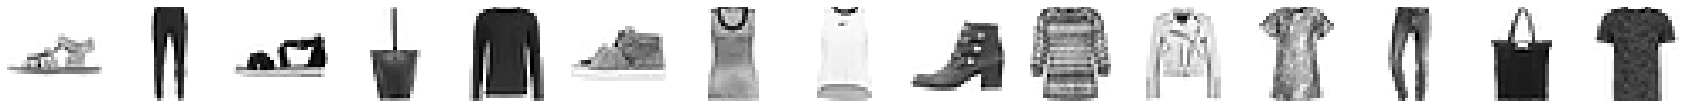

In [7]:
plot_samples(x_train)

## подготовка данных

In [8]:
def im2ar(im): return (im-127.5)/127.5
x_train, x_test = im2ar(x_train), im2ar(x_test)

x_train.shape, y_test.shape

((60000, 28, 28, 1), (10000,))

In [9]:
def one_hot_enc(y,nc=0):
    n = y.shape[0] # количество примеров
    nc = nc if nc>0 else y.max()+1 # количество классов
    assert nc>y.max()
    return np.eye(n,nc)[y]

nc = y_train.max()+1 # количество классов
y_train, y_test = one_hot_enc(y_train,nc=nc),one_hot_enc(y_test,nc=nc)

y_train.shape, y_test.shape

((60000, 10), (10000, 10))

## Модель

In [10]:
import tensorflow as tf
# from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.utils import plot_model

In [11]:
tf.__version__

'2.3.1'

In [12]:
# default GPU device
if tf.test.is_built_with_cuda():
    print([ 
          d.physical_device_desc 
          for d in tf.python.client.device_lib.list_local_devices() 
          if d.device_type == 'GPU' and d.name==tf.test.gpu_device_name()
        ])

['device: 0, name: GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1']


In [13]:
INPUT_SHAPE = x_train.shape[1:]
N_CLASSES = y_train.shape[1]

In [15]:
model = Sequential()
model.add(Input( shape=INPUT_SHAPE, name='input1' ) )
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', name='conv1', ))
model.add(MaxPooling2D(pool_size=2,strides=2, name='mpool1',))
model.add(Conv2D(64, kernel_size=3, padding='same', activation='relu', name='conv2', ))
model.add(Flatten(name='flatten1'))
model.add(Dense(512,activation='relu',name='hidden1',))
model.add(Dense(N_CLASSES, activation='softmax',name='out_softmax',))

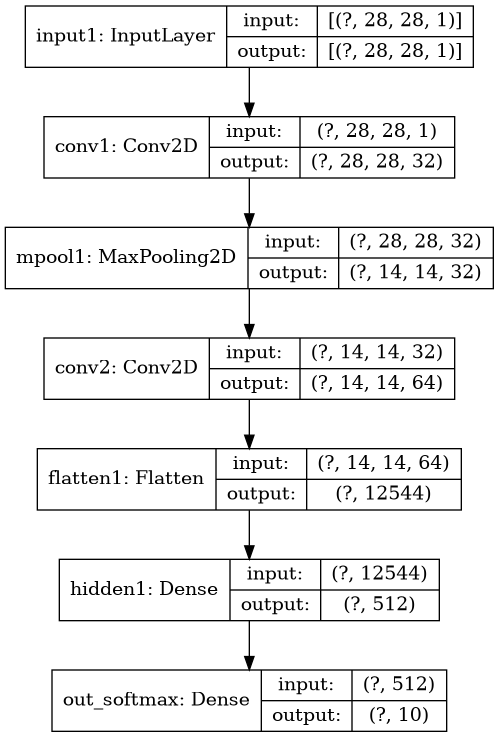

In [16]:
# model.summary()
plot_model(model,to_file='cnn.png', show_layer_names=True, show_shapes=True )

## Обучение

In [17]:
%%time

N_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
VALIDATION_SPLIT = 0.2
LEARNING_RATE = 2e-4

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=["accuracy"])

history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, 
                    epochs=N_EPOCH, 
                    verbose=VERBOSE, 
                    validation_split=VALIDATION_SPLIT)

Epoch 1/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0826 - accuracy: 0.8320 - val_loss: 0.0634 - val_accuracy: 0.8704
Epoch 2/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0573 - accuracy: 0.8854 - val_loss: 0.0564 - val_accuracy: 0.8901
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.0497 - accuracy: 0.9010 - val_loss: 0.0496 - val_accuracy: 0.9030
Epoch 4/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0442 - accuracy: 0.9115 - val_loss: 0.0479 - val_accuracy: 0.9021
Epoch 5/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0404 - accuracy: 0.9201 - val_loss: 0.0451 - val_accuracy: 0.9105
Epoch 6/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0370 - accuracy: 0.9275 - val_loss: 0.0451 - val_accuracy: 0.9086
Epoch 7/20
375/375 [==============================] - 3s 9ms/step - loss: 0.0338 - accuracy: 0.9334 - val_loss: 0.0456 - val_accuracy: 0.9068
Epoch 

## Тестирование

In [18]:
score = model.evaluate(x_test, y_test, verbose=False)
print('Test accuracy:', score[1])

Test accuracy: 0.9180999994277954


In [19]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

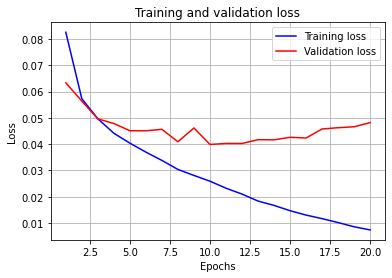

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()

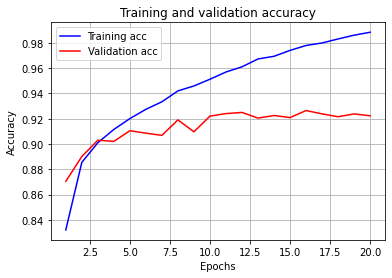

In [21]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.show()

---

In [32]:
# ii = np.random.permutation(x_test.shape[0])[:10]
# p = model.predict(x_test[ii,:])
# r = np.argmax(p,axis=1)
# np.argmax(y_test,axis=1)

In [22]:
def plot_test_samples(X,y,class_names,n_show=25,columns=10,cmap='gray_r'):
    ii = np.random.permutation(X.shape[0])[:n_show]
    
    p = model.predict(X[ii,:])
    r = np.argmax(p,axis=1)
    yii = y[ii]

    plt.figure(figsize=(2*columns,3*(n_show //columns+1)))
    for n,xi in enumerate(X[ii]):
        img = ar2im(xi)
        plt.subplot( n_show//columns+1, columns, n+1)
            
        t = class_names[r[n]] if yii[n]==r[n] else '%s\n[%s]'%(class_names[r[n]],class_names[yii[n]].upper())
        c = 'g' if yii[n]==r[n] else 'r'
        
        plt.title(t,color=c)
        plt.axis(False)
        plt.imshow(img,cmap=cmap)
        

In [23]:
class_names = [ 'футболка', 
                'брюки', 
                'свитер', 
                'платье', 
                'пальто', 
                'сандали', 
                'рубашка', 
                'тапки', 
                'сумка', 
                'полусапожки', ]

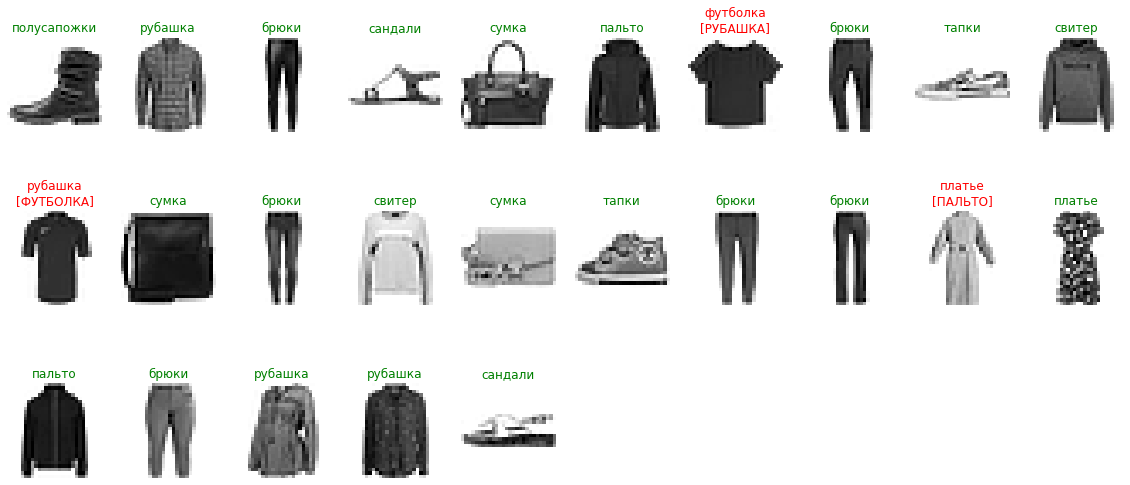

In [35]:
plot_test_samples(x_test,np.argmax(y_test,axis=1),class_names)